# Setup

In [1]:
import sys
from IPython.display import display, HTML
import torch

In [2]:
# Check if GPU is enabled (for Colab users)
in_colab = "google.colab" in sys.modules
if in_colab:
  if torch.cuda.is_available():
      device_name = torch.cuda.get_device_name(0)
      print(f"✅ GPU detected: {device_name}")
  else:
      warning_html = """
      <div style="background-color:#fff3cd;border:1px solid #ffeeba;
                  padding:15px;border-radius:8px;">
          ⚠️ <b>No GPU detected.</b><br>
          To speed up model inference:
          <ol>
              <li>Click on <b>Runtime</b> (top menu)</li>
              <li>Select <b>Change runtime type</b></li>
              <li>Set <b>Hardware accelerator</b> to <b>GPU</b></li>
              <li>Then re-run this notebook.</li>
          </ol>

          Or, you can continue to the next cells but it will take a while running on CPU... up to you!
      </div>
      """
      display(HTML(warning_html))
      device = torch.device("cpu")
      raise RuntimeError(
          "⚠️ No GPU detected. Please change: Runtime > Change runtime type > GPU."
      )

RuntimeError: ⚠️ No GPU detected. Please change: Runtime > Change runtime type > GPU.

In [3]:
if in_colab:
    # Clone GitHub repo and move into it
    !git clone https://github.com/championjeyson/agb-prediction.git
    %cd agb-prediction

    # Install dependencies
    !pip install -r requirements.txt

    # # Make sure src/ is importable
    # sys.path.append("src")

else:
    # Make sure src/ is importable
    sys.path.append("..")
    # sys.path.append("../src")

Cloning into 'agb-prediction'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 259 (delta 102), reused 156 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (259/259), 34.90 MiB | 3.44 MiB/s, done.
Resolving deltas: 100% (102/102), done.
Filtering content: 100% (19/19), 300.72 MiB | 37.54 MiB/s, done.
/content/agb-prediction
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 4.2 MB/s eta 0:00:00
   

In [63]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import xarray as xr
import rasterio
from rasterio.plot import show
import rioxarray
from pathlib import Path
import contextily as ctx

# We need these because we're checking intermediate files...
from src.constants import *
from src.utils.config import *
from src.imagery_processing import (
    process_s2_data,
    process_alos_data,
    process_dem_data,
    normalize_bands
)
from src.models import (
    load_model_config,
    load_model_data_statistics,
)

# ... but otherwise, only that is needed to run inference
from src.inference import run_inference

In [50]:
# Load common config to access wanted chunksize
CFG = get_config("default.yaml")
CHUNKSIZE = get_chunk_size(CFG)

# Load input data statistics and model configuration files
model_norm_values = load_model_data_statistics()
model_cfg = load_model_config()

# Set some parameters
longer_dim_figsize = 6

# Visualize some of the inputs
Note that this will only be possible for small emough imagery. Although computation is done for small chucks, the plotting is done for the full images, which might be limited depending on the resources available.

## Sentinel-2 Imagery

Applying offset on S2 data


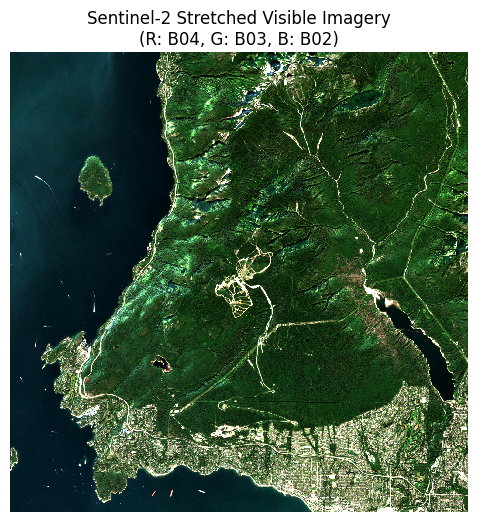

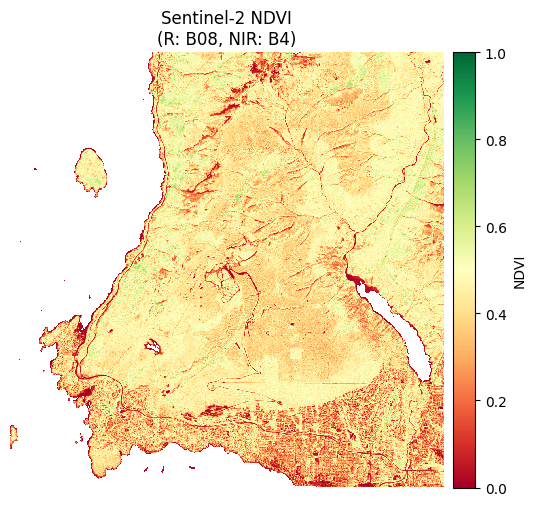

In [51]:
# Process Sentinel-2 data
dict_s2_processed_bands, mask, xds_s2_ref_band, *_ = process_s2_data()

# Extract and display visible imagery (stretched)
s2_rgb = xr.concat([dict_s2_processed_bands['B04'], dict_s2_processed_bands['B03'], dict_s2_processed_bands['B02']], dim='band').transpose("y", "x", "band")
p2, p98 = np.percentile(s2_rgb, (2, 98))
s2_rgb_stretch = np.clip((s2_rgb - p2) / (p98 - p2), 0, 1)

figsize = (np.array(s2_rgb.shape[:2]))/max(s2_rgb.shape[:2]) * longer_dim_figsize

fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(s2_rgb_stretch, interpolation='none')
ax.set_title("Sentinel-2 Stretched Visible Imagery\n(R: B04, G: B03, B: B02)")
ax.axis("off")

# Extract and display NDVI image
nir = dict_s2_processed_bands["B08"]
red = dict_s2_processed_bands["B04"]
s2_ndvi = (nir - red) / (nir + red)
s2_ndvi = np.where(mask, np.nan, s2_ndvi)

fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(s2_ndvi, cmap="RdYlGn", vmin=0, vmax=1, interpolation='none')
ax.set_title("Sentinel-2 NDVI\n(R: B08, NIR: B4)")
ax.axis("off")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = fig.colorbar(im, cax=cax)
cb.set_label("NDVI")

plt.show()

Text(0.5, 0.98, 'Sentinel-2 Normalized Bands (Input Features)')

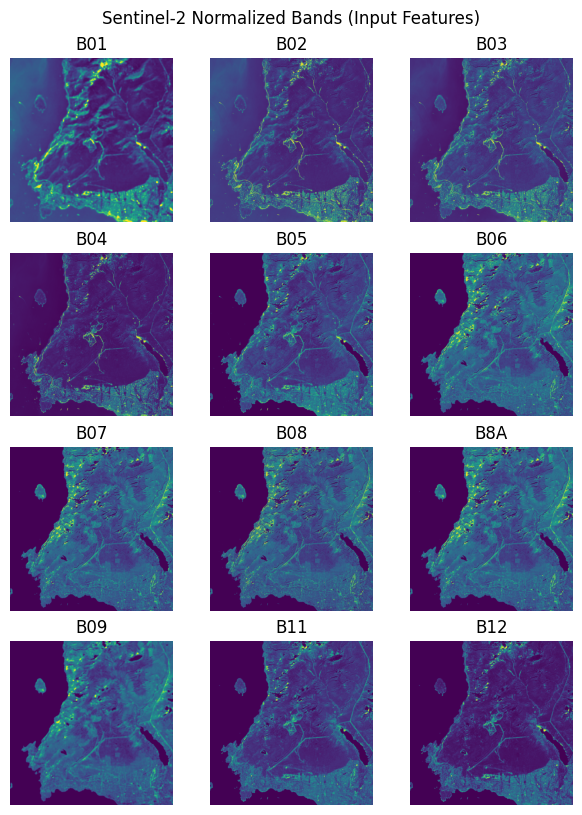

In [52]:
# Stack and reorder bands
s2_band_order = model_cfg['bands']
s2_processed_bands = xr.concat([dict_s2_processed_bands[band] for band in s2_band_order], dim="band")
s2_processed_bands = s2_processed_bands.assign_coords(band=s2_band_order)
# Reorder dimensions
s2_processed_bands = s2_processed_bands.transpose("y", "x", "band")
# Normalize bands according to the statistics used in the model
s2_processed_bands_normalized = normalize_bands(s2_processed_bands, model_norm_values['S2_bands'], s2_band_order, model_cfg['norm_strat'], NODATAVALS['S2_bands'])

# Plot
nrows, ncolumns = 4, 3
aspect_ratio_height_over_width = s2_processed_bands_normalized.shape[0]/s2_processed_bands_normalized.shape[1]
figsize = (longer_dim_figsize*1, longer_dim_figsize*aspect_ratio_height_over_width*nrows/ncolumns)
fig, ax = plt.subplots(nrows, ncolumns, figsize=figsize, layout="constrained")
axr = ax.ravel()
for iband, band in enumerate(s2_processed_bands_normalized.band.values):
  im = axr[iband].imshow(s2_processed_bands_normalized.sel(band=band))
  axr[iband].set_title(band)
  axr[iband].axis('off')
fig.suptitle('Sentinel-2 Normalized Bands (Input Features)')

## ALOS PALSAR-2 Imagery

(np.float64(-0.5), np.float64(1506.5), np.float64(1513.5), np.float64(-0.5))

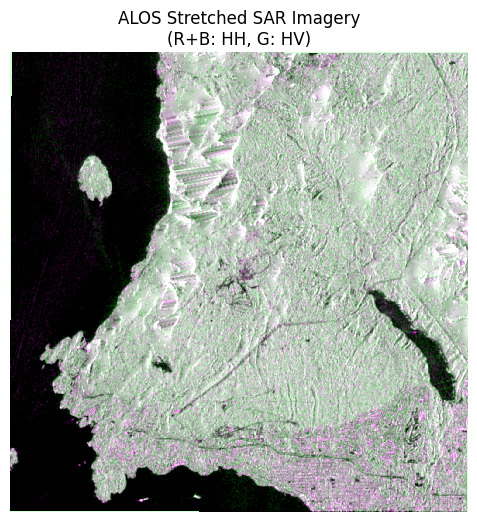

In [53]:
# Process ALOS data
xds_alos_gamma = process_alos_data(xds_s2_ref_band)

# Extract and display SAR imagery (stretched)
bands = ['HH', 'HV', 'HH']
da_list = [ xds_alos_gamma.sel(band=b) for b in bands ]
stretched_list = []
for da in da_list:
    plow = np.nanpercentile(da, 20)
    p98 = np.nanpercentile(da, 98)
    stretched = (da - plow) / (p98 - plow)
    stretched = stretched.clip(0, 1)
    stretched_list.append(stretched)
xds_alos_gamma_rgb_stretch = xr.concat(stretched_list, dim='band').transpose("y", "x", "band")

figsize = (np.array(xds_alos_gamma_rgb_stretch.shape[:2]))/max(xds_alos_gamma_rgb_stretch.shape[:2]) * longer_dim_figsize

fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(xds_alos_gamma_rgb_stretch, interpolation='none')
ax.set_title("ALOS Stretched SAR Imagery\n(R+B: HH, G: HV)")
ax.axis("off")

Text(0.5, 0.98, 'ALOS PALSAR-2 Normalized Bands (Input Features)')

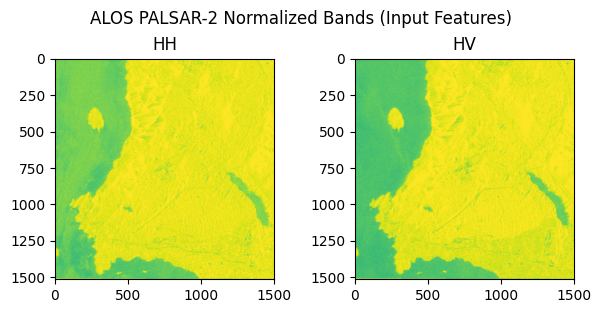

In [54]:
alos_order = ['HH', 'HV']
xds_alos_gamma_normalized = normalize_bands(xds_alos_gamma, model_norm_values['ALOS_bands'], alos_order, model_cfg['norm_strat'], NODATAVALS['ALOS_bands'])

nrows, ncolumns = 1, 2
aspect_ratio_height_over_width = xds_alos_gamma_normalized.shape[0]/xds_alos_gamma_normalized.shape[1]
figsize = (longer_dim_figsize*1, longer_dim_figsize*aspect_ratio_height_over_width*nrows/ncolumns)
fig, ax = plt.subplots(nrows, ncolumns, figsize=figsize, layout="constrained")
axr = ax.ravel()
for iband, band in enumerate(xds_alos_gamma_normalized.band.values):
  im = axr[iband].imshow(xds_alos_gamma_normalized.sel(band=band))
  axr[iband].set_title(band)
fig.suptitle('ALOS PALSAR-2 Normalized Bands (Input Features)')

## Digital Elevation Model (DEM)

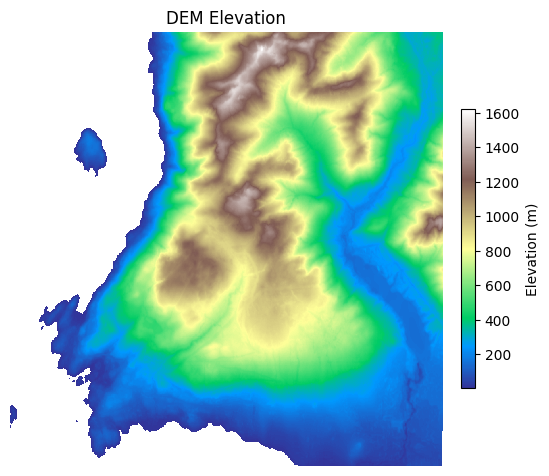

In [57]:
# Process DEM data
xds_dem = process_dem_data(xds_s2_ref_band)
xds_dem = xds_dem.where(xds_dem > 0, np.nan)

# Create figure
figsize = (np.array(xds_alos_gamma_rgb_stretch.shape[:2]))/max(xds_alos_gamma_rgb_stretch.shape[:2]) * longer_dim_figsize
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(xds_dem, cmap='terrain', interpolation='none')
ax.set_title("DEM Elevation")
ax.axis("off")

# Add colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("Elevation (m)")

plt.show()

Text(0.5, 1.0, 'DEM Normalized (Input Feature)')

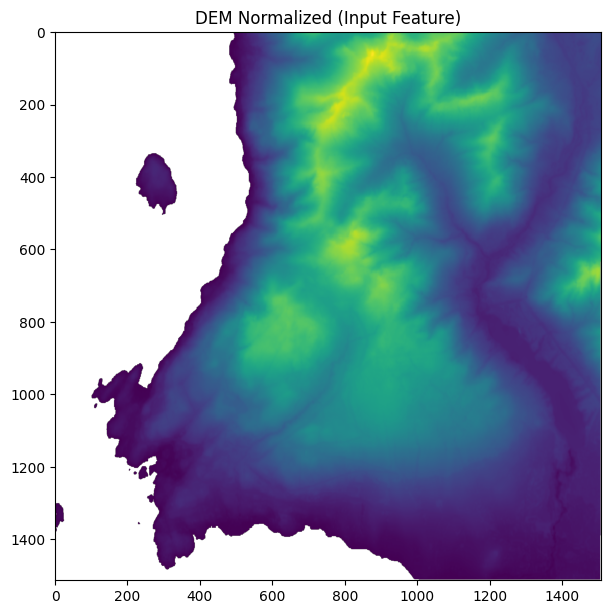

In [59]:
xds_dem_normalized = normalize_bands(xds_dem, model_norm_values['DEM'], None, model_cfg['norm_strat'], NODATAVALS['DEM'])

aspect_ratio_height_over_width = xds_dem_normalized.shape[0]/xds_dem_normalized.shape[1]
figsize = (longer_dim_figsize*1, longer_dim_figsize*aspect_ratio_height_over_width)
fig, ax = plt.subplots(figsize=figsize, layout="constrained")
im = ax.imshow(xds_dem_normalized)
ax.set_title('DEM Normalized (Input Feature)')

# Run inference
If using the example provided, and the GPU under the free plan of Google Colab, it should take about 5 minutes to run.

In [ ]:
run_inference()

# Visualize output

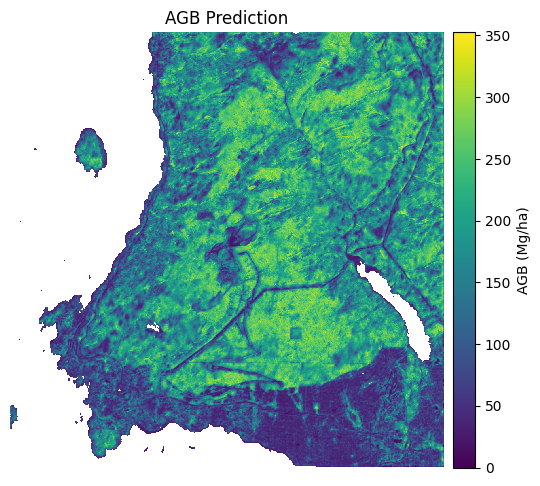

In [64]:


# Load image
agb_prediction_path = Path('./output/agb_prediction.tif')
xds_agb = rioxarray.open_rasterio(
    agb_prediction_path,
    masked=True,
    chunks=(1, CHUNKSIZE, CHUNKSIZE)
).squeeze()
agb = np.where(mask, np.nan, xds_agb)

# Plot image

figsize = (np.array(xds_agb.shape[:2]))/max(xds_agb.shape[:2]) * longer_dim_figsize

fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(agb, cmap="viridis", vmin=0, interpolation='none')
ax.set_title("AGB Prediction")
ax.axis("off")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = fig.colorbar(im, cax=cax)
cb.set_label("AGB (Mg/ha)")

ax.set_aspect('equal')
plt.show()

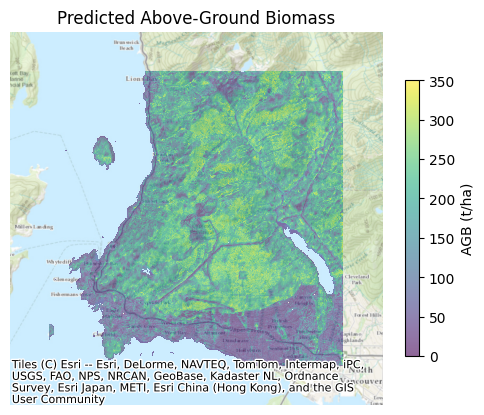

In [67]:
# Plot
figsize = (np.array(xds_agb.shape[:2]))/max(xds_agb.shape[:2]) * longer_dim_figsize
fig, ax = plt.subplots(figsize=figsize)

# Plot raster
im = xds_agb.plot(
    ax=ax,
    alpha=0.6,
    cmap="viridis",
    vmin=0,
    vmax=min(np.nanmax(xds_agb.values), 350),
    add_colorbar=False  # disable automatic colorbar
)

# Add a smaller colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.6)  # shrink: fraction of original size
cbar.set_label("AGB (t/ha)")

# Zoom out by expanding x and y limits
pad = 2000
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim[0] - 2000, xlim[1] + 2000)
ax.set_ylim(ylim[0] - 2000, ylim[1] + 2000)

ax.set_aspect('equal')
ax.set_title('Predicted Above-Ground Biomass')
# ax.set_xlabel('Eastings (m)')
# ax.set_ylabel('Northings (m)')
ax.axis('off')

# Get raster bounds
xmin, ymin, xmax, ymax = xds_agb.rio.bounds()

# Compute center
x_center = (xmin + xmax) / 2
y_center = (ymin + ymax) / 2

# Optional: add a background using contextily
ctx.add_basemap(ax, crs=xds_s2_ref_band.rio.crs, source=ctx.providers.Esri.WorldTopoMap) #ctx.providers.OpenTopoMap)
plt.show()
